# Libraries

In [1]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.signal import detrend
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import ancova
from matplotlib.patches import Patch
#import statannotations as sa
from statannotations.Annotator import Annotator
import xlsxwriter
import lxml

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from datetime import datetime
from __future__ import absolute_import, print_function

from neuroCombat import neuroCombat
from neuroCombat import neuroCombatFromTraining
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Directories

In [2]:
ROOT = Path().resolve().parent      # one level up from current dir
fmri_df = pd.read_excel(ROOT / "data/Simultaneous_PET_fMRI/fmri_results.xlsx")
pet_df = pd.read_excel(ROOT / "data/Simultaneous_PET_fMRI/pet_results.xlsx")
timeseries_Panel_B_df = pd.read_csv(ROOT / "data/Simultaneous_PET_fMRI/all_timeseries_Panel_A.csv")
timeseries_df = pd.read_csv(ROOT / "data/Simultaneous_PET_fMRI/all_timeseries.csv")

# Set Tick Size

In [3]:
sns.set(rc={'axes.linewidth': 2.0})
sns.set_style("white")
sns.set_style("ticks")

# Prep the dataframes

In [4]:
fmri = fmri_df
pet = pet_df  
timeseries_Panel_B = timeseries_Panel_B_df
all_timeseries = timeseries_df

# Prep the dataframes - filter data

In [ ]:
# Define a functio to split the table in first session and both sessions
def extract_last_digit_and_filter(df):
    # Extract the last digit of the 'subID' column
    df['session'] = df['subID'].astype(str).str[-1]
    
    # Convert the last digit to integer type
    df['session'] = df['session'].astype(int)
    
    # Create a new DataFrame with rows where 'session' equals 1
    original_name_first_session = df[df['session'] == 1].copy()
    
    return original_name_first_session


pd.set_option('display.max_rows', None)



# Merge the dataframes
fmri_first_session = extract_last_digit_and_filter(fmri)

# Extract the first number after 'sub-' and classify
fmri_first_session['sub_id_categorical'] = fmri_first_session['subID'].apply(
    lambda x: 1 if x.split('-')[1].startswith('1') else 0
)

fmri_first_session['group'] = fmri_first_session['subID'].apply(
    lambda x: 'Patient' if x.split('-')[1].startswith('1') else 'Healthy Control'
)

hc_fmri_first_session = fmri_first_session[(fmri_first_session['sub_id_categorical'] == 0)]

# Concatenating all the data into one big dataframe
bimodal = pd.merge(fmri,pet,on='subID',how='inner')
bimodal = bimodal.dropna(subset=['subID'])

# Extract the first number after 'sub-' and classify
bimodal['sub_id_categorical'] = bimodal['subID'].apply(
    lambda x: 1 if x.split('-')[1].startswith('1') else 0
)

bimodal['group'] = bimodal['subID'].apply(
    lambda x: 'Patient' if x.split('-')[1].startswith('1') else 'Healthy Control'
)


bimodal_first_session = extract_last_digit_and_filter(bimodal)
hc_bimodal = bimodal[(bimodal['sub_id_categorical'] == 0)]
hc_bimodal_first_session = extract_last_digit_and_filter(hc_bimodal)


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6141/3055318069.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session'] = df['subID'].astype(str).str[-1]
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6141/3055318069.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session'] = df['session'].astype(int)


# Edit the RC file

In [6]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "svg.fonttype": "none"
})

# Panel S2B, D


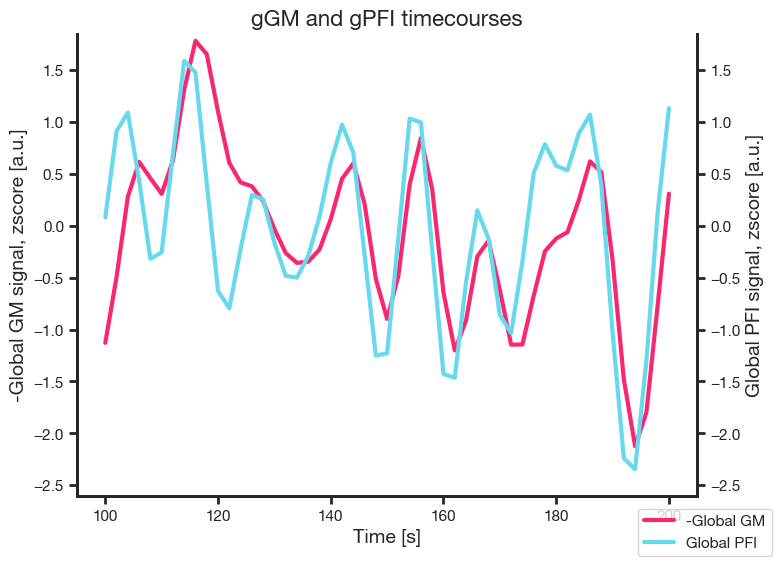

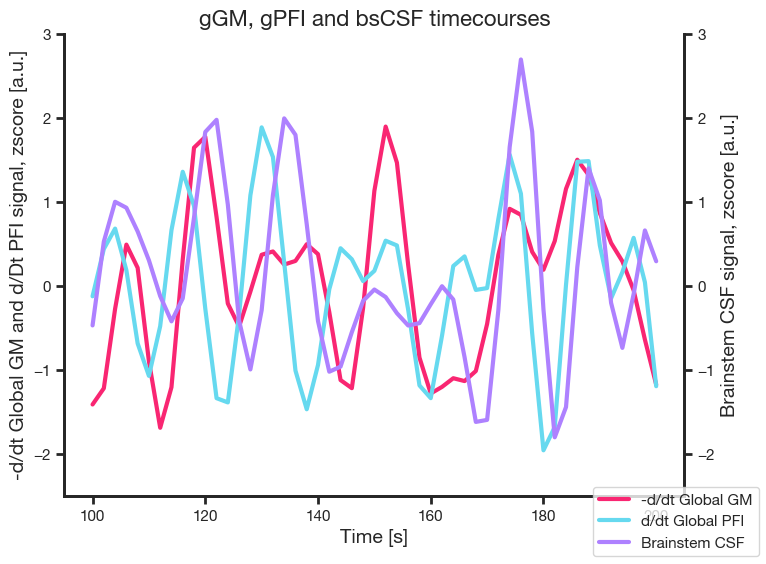

In [13]:
pd.set_option('display.max_columns', None)



rest_timecourse = timeseries_Panel_B
subject_row = rest_timecourse[rest_timecourse['subID'] == 'sub-002-1']
subject_index = subject_row.index[0]  # Change this to the specific row index of your subject



rest_timecourse_dataframe = pd.DataFrame()
# Filter the dataframe for the chosen subject
rest_timecourse_dataframe = rest_timecourse.iloc[[subject_index]]


# Select columns that start with "gm_tc"
gm_tc_columns = [col for col in rest_timecourse_dataframe.columns if col.startswith("gm_tc")]
pfi_tc_columns = [col for col in rest_timecourse_dataframe.columns if col.startswith("pfi_tc")]

#print(len(gm_tc_columns))
# Concatenate the selected columns along axis=0 (stacking them)
gm_values = pd.concat([rest_timecourse_dataframe[col] for col in gm_tc_columns], axis=0).reset_index(drop=True)
gm_values = stats.zscore(gm_values)
pfi_values = pd.concat([rest_timecourse_dataframe[col] for col in pfi_tc_columns], axis=0).reset_index(drop=True)
pfi_values = stats.zscore(pfi_values)





rest_timecourse_new_one = pd.DataFrame()
rest_timecourse_new_one['timepoints'] = ((pd.Series(range(1, len(gm_values) + 1))) * 2) + 5 * 2 # This is the rest TR
rest_timecourse_new_one['global_gm'] = -gm_values
rest_timecourse_new_one['global_pfi'] = pfi_values

rest_timecourse_new_one_short = rest_timecourse_new_one[(rest_timecourse_new_one['timepoints'] >= 100) & (rest_timecourse_new_one['timepoints'] <= 200)]

fig,ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()  # Create secondary y-axis

sns.lineplot(x="timepoints", y='global_gm', data=rest_timecourse_new_one_short, ax=ax1, label='-Global GM', color=(249/255, 38/255, 114/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='global_pfi', data=rest_timecourse_new_one_short, ax=ax2, label='Global PFI', color=(102/255, 217/255, 239/255), linewidth=3, legend=False)


# Set labels
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('-Global GM signal, zscore [a.u.]', fontsize=14)
ax2.set_ylabel('Global PFI signal, zscore [a.u.]', fontsize=14)

# Adjust ticks
ax1.tick_params(axis='y')
ax1.set_ylim(-2.6,1.85)
ax2.set_ylim(-2.6,1.85)
ax2.tick_params(axis='y')

plt.title(f'gGM and gPFI timecourses',fontsize = 16, weight = 'bold')
ax1.tick_params(axis='x', which='both', direction='out', width=2)
ax1.tick_params(axis='y', which='both', direction='out', width=2)
ax2.tick_params(axis='x', which='both', direction='out', width=2)
ax2.tick_params(axis='y', which='both', direction='out', width=2)

fig.legend(loc='lower right')
sns.despine(right=False, left=False)

# Save the figure -------
#image_path = os.path.join(outDir, f'Rest_timecourse_1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Rest_timecourse_1.svg')
#fig.savefig(image_path_svg)

#------------------------



# Read the excel file into a dataframe
rest_timecourse = all_timeseries
subject_row = rest_timecourse[rest_timecourse['subID'] == 'sub-004-1'] 
subject_index = subject_row.index[0]  # Change this to the specific row index of your subject

#print(wake_timecourse)

rest_timecourse_dataframe = pd.DataFrame()
# Filter the dataframe for the chosen subject
rest_timecourse_dataframe = rest_timecourse.iloc[[subject_index]]


# Select columns that start with "gm_tc"
gm_tc_columns = [col for col in rest_timecourse_dataframe.columns if col.startswith("gm_derivative")]
pfi_tc_columns = [col for col in rest_timecourse_dataframe.columns if col.startswith("pfi_derivative")]
csf_tc_columns = [col for col in rest_timecourse_dataframe.columns if col.startswith("csf_tc")]

#print(pfi_tc_columns)
# Concatenate the selected columns along axis=0 (stacking them)
gm_values = pd.concat([rest_timecourse_dataframe[col] for col in gm_tc_columns], axis=0).reset_index(drop=True)
gm_values = stats.zscore(gm_values)
pfi_values = pd.concat([rest_timecourse_dataframe[col] for col in pfi_tc_columns], axis=0).reset_index(drop=True)
pfi_values = stats.zscore(pfi_values)
csf_values = pd.concat([rest_timecourse_dataframe[col] for col in csf_tc_columns], axis=0).reset_index(drop=True)
csf_values = stats.zscore(csf_values)

rest_timecourse_new_two = pd.DataFrame()
rest_timecourse_new_two['timepoints'] = ((pd.Series(range(1, len(gm_values) + 1))) * 2) + 5 * 2 # This is the rest TR
rest_timecourse_new_two['global_gm'] = -gm_values
rest_timecourse_new_two['global_pfi'] = pfi_values
rest_timecourse_new_two['brainstem_csf'] = csf_values

rest_timecourse_new_two_short = rest_timecourse_new_two[(rest_timecourse_new_two['timepoints'] >= 100) & (rest_timecourse_new_two['timepoints'] <= 200)]



fig,ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()  # Create secondary y-axis

sns.lineplot(x="timepoints", y='global_gm', data=rest_timecourse_new_two_short, ax=ax1, label='-d/dt Global GM', color=(249/255, 38/255, 114/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='global_pfi', data=rest_timecourse_new_two_short, ax=ax1, label='d/dt Global PFI', color=(102/255, 217/255, 239/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='brainstem_csf', data=rest_timecourse_new_two_short, ax=ax2, label='Brainstem CSF', color=(174/255, 129/255, 255/255), linewidth=3, legend=False)



# Set labels
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('-d/dt Global GM and d/Dt PFI signal, zscore [a.u.]', fontsize=14)
ax2.set_ylabel('Brainstem CSF signal, zscore [a.u.]', fontsize=14)

# Adjust ticks
ax1.tick_params(axis='y')
ax1.set_ylim(-2.5,3)
ax2.set_ylim(-2.5,3)
ax2.tick_params(axis='y')

plt.title(f'gGM, gPFI and bsCSF timecourses',fontsize = 16, weight = 'bold')
ax1.tick_params(axis='x', which='both', direction='out', width=2)
ax1.tick_params(axis='y', which='both', direction='out', width=2)
ax2.tick_params(axis='x', which='both', direction='out', width=2)
ax2.tick_params(axis='y', which='both', direction='out', width=2)

fig.legend(loc='lower right')
sns.despine(right=False, left=False)


# Save the figure -------
#image_path = os.path.join(outDir, f'Rest_timecourse_2.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Rest_timecourse_2.svg')
#fig.savefig(image_path_svg)



# Panel S2C, E - left

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
-2
-0.5211568117760824
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
-4
0.4042913932425015


Text(0.6, 0.2, 'Rmax lag = -4.0s')

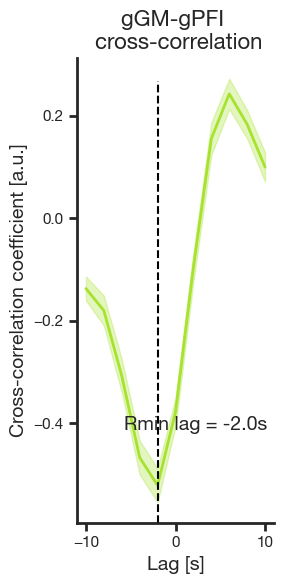

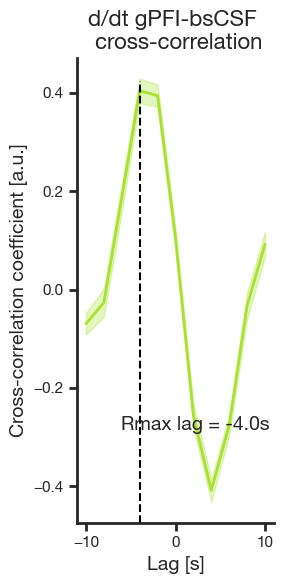

In [15]:
# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Show full content in each column (no truncation)
pd.set_option('display.max_colwidth', None)



###

# Extract lag numbers from column names
lag_numbers = [int(col.split('_')[-1]) for col in hc_fmri_first_session.columns if col.startswith('xcorr_ventricle_gm_')]
lag_numbers.sort()  # Sort lag numbers in ascending order
print(lag_numbers)
# Calculate mean and standard error of the mean (SEM) across all subjects for each time lag
mean_values = hc_fmri_first_session[[f'xcorr_ventricle_gm_{lag}' for lag in lag_numbers]].mean(axis=0)
sem_values = hc_fmri_first_session[[f'xcorr_ventricle_gm_{lag}' for lag in lag_numbers]].sem(axis=0)

# Convert to arrays for plotting
time_lags = lag_numbers
time_lags_plot = np.arange(-10, 11)
time_lags_plot = time_lags_plot * 2 # This is the rest TR
mean_values_array = mean_values.values
sem_values_array = sem_values.values

max_y_index = np.argmin(mean_values_array)
max_y = mean_values_array[max_y_index]
max_x = time_lags_plot[max_y_index]

print(max_x)
print(max_y)

time_lags_plot = time_lags_plot[5:-5] 
mean_values_array = mean_values_array[5:-5]
sem_values_array = sem_values_array[5:-5]


fig = plt.figure(figsize=(3, 6))

# Plot the mean line with error bars
xcorr_mean = sns.lineplot(x=time_lags_plot, y=mean_values_array, color=(166/255, 226/255, 46/255), linewidth=2)
xcorr_mean.fill_between(time_lags_plot,mean_values_array-sem_values_array,mean_values_array+sem_values_array, color=(166/255, 226/255, 46/255), alpha=0.3)
xcorr_mean.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
xcorr_mean.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed

# Annotate the maximum value with its x and y values

xcorr_mean.axvline(x=max_x, linestyle='--', color='black', linewidth=1.5, ymax=0.95)

xcorr_mean.set_title("gGM-gPFI \n cross-correlation",fontsize = 16,weight='bold', loc='center')
xcorr_mean.set_xlabel('Lag [s]', fontsize = 14)
xcorr_mean.set_ylabel('Cross-correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()

plt.text(0.6, 0.2, f"Rmin lag = {max_x:.1f}s", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Rest_cross_corr_1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Rest_cross_corr_1.svg')
#fig.savefig(image_path_svg)


# Plot new
lag_numbers = [int(col.split('_')[-1]) for col in hc_fmri_first_session.columns if col.startswith('xcorr_ventricle_csf_')]
lag_numbers.sort()  # Sort lag numbers in ascending order
print(lag_numbers)
# Calculate mean and standard error of the mean (SEM) across all subjects for each time lag
mean_values = hc_fmri_first_session[[f'xcorr_ventricle_csf_{lag}' for lag in lag_numbers]].mean(axis=0)
sem_values = hc_fmri_first_session[[f'xcorr_ventricle_csf_{lag}' for lag in lag_numbers]].sem(axis=0)

# Convert to arrays for plotting
time_lags = lag_numbers
time_lags_plot = np.arange(-10, 11)
time_lags_plot = time_lags_plot * 2 # This is the rest TR
mean_values_array = mean_values.values
sem_values_array = sem_values.values

max_y_index = np.argmax(mean_values_array)
max_y = mean_values_array[max_y_index]
max_x = time_lags_plot[max_y_index]

print(max_x)
print(max_y)

#Adjust so they only show the -10 - 10s mark
time_lags_plot = time_lags_plot[5:-5]
mean_values_array = mean_values_array[5:-5]
sem_values_array = sem_values_array[5:-5]


fig = plt.figure(figsize=(3, 6))

# Plot the mean line with error bars
xcorr_mean = sns.lineplot(x=time_lags_plot, y=mean_values_array, color=(166/255, 226/255, 46/255), linewidth=2)
xcorr_mean.fill_between(time_lags_plot,mean_values_array-sem_values_array,mean_values_array+sem_values_array, color=(166/255, 226/255, 46/255), alpha=0.3)
xcorr_mean.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
xcorr_mean.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed

# Annotate the maximum value with its x and y values

xcorr_mean.axvline(x=max_x, linestyle='--', color='black', linewidth=1.5, ymax=0.95)

xcorr_mean.set_title("d/dt gPFI-bsCSF \n cross-correlation",fontsize = 16,weight='bold', loc='center')
xcorr_mean.set_xlabel('Lag [s]', fontsize = 14)
xcorr_mean.set_ylabel('Cross-correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()

plt.text(0.6, 0.2, f"Rmax lag = {max_x:.1f}s", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Rest_cross_corr_2_new.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Rest_cross_corr_2_new.svg')
#fig.savefig(image_path_svg)



# Panel S2C, E - right

Mean: -0.504, Standard Deviation: 0.210
t-statistic: -16.228414360026775
p-value: 1.990857065642399e-20
Mean: 0.299, Standard Deviation: 0.149
t-statistic: 13.620939326972861
p-value: 1.42487904660466e-17


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6141/94898035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_fmri_first_session['pair_name'] = "gGM-gPFI"
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6141/94898035.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_fmri_first_session['pair_name'] = "gPFI-bsCSF"


Text(0.5, 0.97, '****')

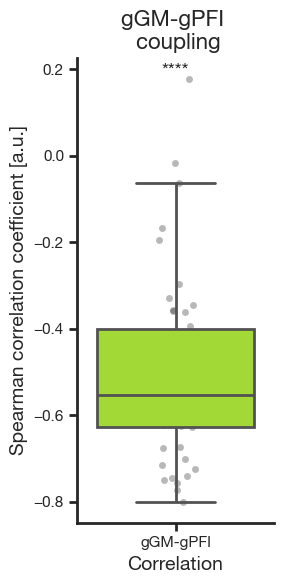

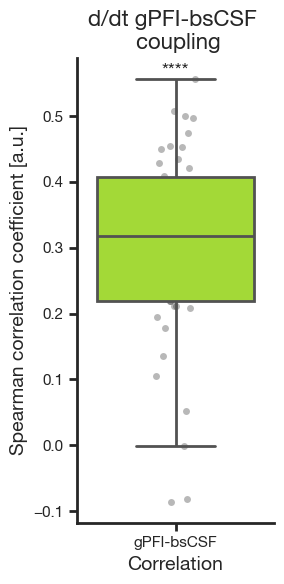

In [16]:
###
# 2 - A. Prove that the correlation values across subjects and modalities show similar distribution
hc_fmri_first_session['pair_name'] = "gGM-gPFI"

fig = plt.figure(figsize=(3, 6))


ax = sns.stripplot(data=hc_fmri_first_session, x="pair_name", y="r_ventricle_gm",color='black', dodge=True, alpha=0.28, zorder = 0)
stripplot = sns.boxplot(data=hc_fmri_first_session, x="pair_name", y="r_ventricle_gm",saturation=0.9, linewidth=2,flierprops=dict(marker='o', markersize=3), color=(166/255, 226/255, 46/255), showfliers=False)
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
plt.title(f'gGM-gPFI \n coupling',fontsize = 16, weight = 'bold')
plt.xlabel('Correlation', fontsize = 14)
plt.ylabel('Spearman correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()  # Adjust spines


# statistic whether it is different to zero
data = hc_fmri_first_session['r_ventricle_gm']
#print(data)

# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(data, 0, nan_policy='omit')

mean_val = hc_fmri_first_session['r_ventricle_gm'].mean()
std_val = hc_fmri_first_session['r_ventricle_gm'].std()

print(f"Mean: {mean_val:.3f}, Standard Deviation: {std_val:.3f}")
# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Annotate the plot with the t-test result
# Format p-value
if p_value < 0.0001:
    p_str = '****'
else:
    p_str = f'p = {p_value:.3f}'

# Add the calculated p-value as custom text on the plot
plt.text(0.5, 0.97, f"{p_str}", ha='center', va='center', transform=ax.transAxes, fontsize=14)



# Save the figure -------
#image_path = os.path.join(outDir, f'Rest_boxplot_1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Rest_boxplot_1.svg')
#fig.savefig(image_path_svg)



# New Boxplot without the rest
hc_fmri_first_session['pair_name'] = "gPFI-bsCSF"

fig = plt.figure(figsize=(3, 6))


ax = sns.stripplot(data=hc_fmri_first_session, x="pair_name", y="r_ventricle_csf",color='black', dodge=True, alpha=0.28, zorder = 0)
stripplot = sns.boxplot(data=hc_fmri_first_session, x="pair_name", y="r_ventricle_csf",saturation=0.9, linewidth=2,flierprops=dict(marker='o', markersize=3), color=(166/255, 226/255, 46/255), showfliers=False)
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
plt.title(f"d/dt gPFI-bsCSF \n coupling",fontsize = 16, weight = 'bold')
plt.xlabel('Correlation', fontsize = 14)
plt.ylabel('Spearman correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()  # Adjust spines


# statistic whether it is different to zero
data = hc_fmri_first_session['r_ventricle_csf']
#print(data)
mean_val = hc_fmri_first_session['r_ventricle_csf'].mean()
std_val = hc_fmri_first_session['r_ventricle_csf'].std()

print(f"Mean: {mean_val:.3f}, Standard Deviation: {std_val:.3f}")
# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(data, 0, nan_policy='omit')

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Annotate the plot with the t-test result
# Format p-value
if p_value < 0.0001:
    p_str = '****'
else:
    p_str = f'p = {p_value:.3f}'

# Add the calculated p-value as custom text on the plot
plt.text(0.5, 0.97, f"{p_str}", ha='center', va='center', transform=ax.transAxes, fontsize=14)


# Save the figure -------
#image_path = os.path.join(outDir, f'Rest_boxplot_2_new.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Rest_boxplot_2_new.svg')
#fig.savefig(image_path_svg)



In [17]:
hc_bimodal_first_session['gm_amplitude_normalized'] = hc_bimodal_first_session['gm_amplitude_normalized']*100
hc_bimodal_first_session['partial_volume_effect_amplitude_normalized'] = hc_bimodal_first_session['partial_volume_effect_amplitude_normalized']*100
hc_bimodal_first_session['partial_volume_effect_confidence_interval_normalized'] = hc_bimodal_first_session['partial_volume_effect_confidence_interval_normalized']*100
hc_bimodal['ventricular_slope'] = hc_bimodal['ventricular_slope'] * 300
hc_bimodal_first_session['ventricular_slope'] = hc_bimodal_first_session['ventricular_slope'] * 300
hc_bimodal['brain_slope'] = hc_bimodal['brain_slope'] * 300
hc_bimodal_first_session['brain_slope'] = hc_bimodal_first_session['brain_slope'] * 300

/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6141/1054140595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_bimodal['ventricular_slope'] = hc_bimodal['ventricular_slope'] * 300
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_6141/1054140595.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_bimodal['brain_slope'] = hc_bimodal['brain_slope'] * 300


# Fig. S2A, G, H

           n         r          CI95%     p-val     power
spearman  45 -0.054941  [-0.34, 0.24]  0.720004  0.064602
           n         r         CI95%     p-val     power
spearman  45  0.237813  [-0.06, 0.5]  0.115703  0.354337
           n         r          CI95%     p-val     power
spearman  45 -0.189855  [-0.46, 0.11]  0.211612  0.241521


Text(0.5, 0.98, 'r = -0.19, p = 0.212, n = 45')

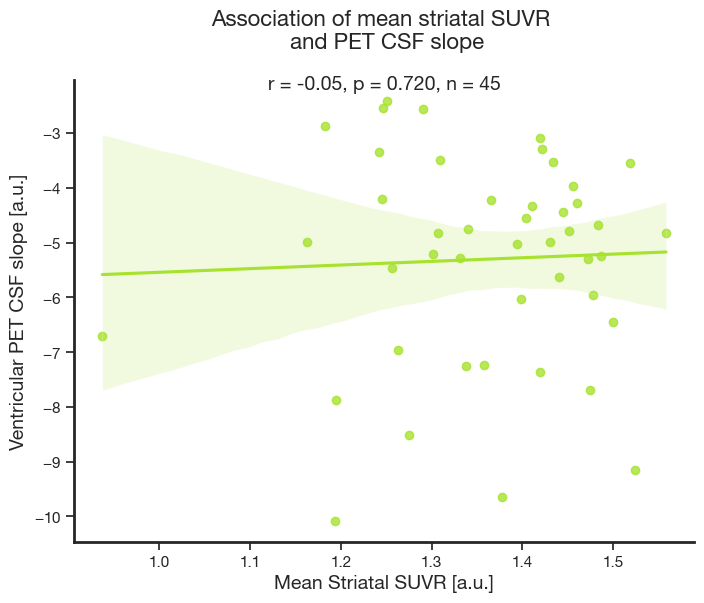

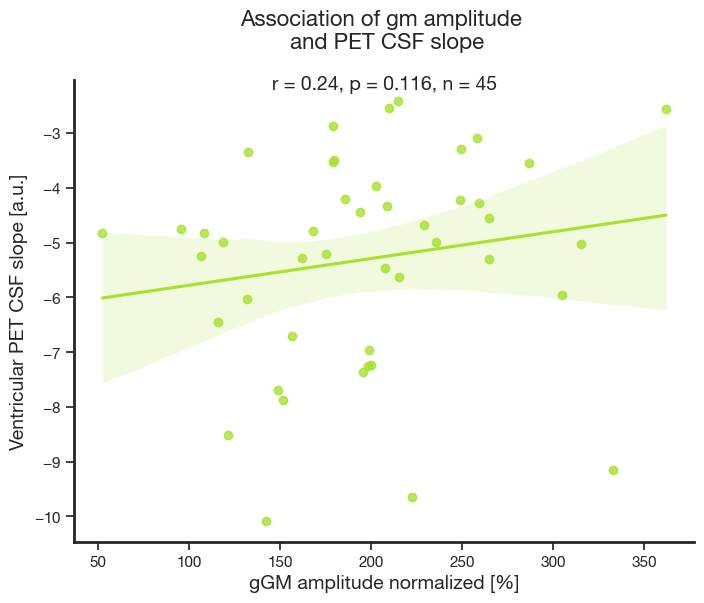

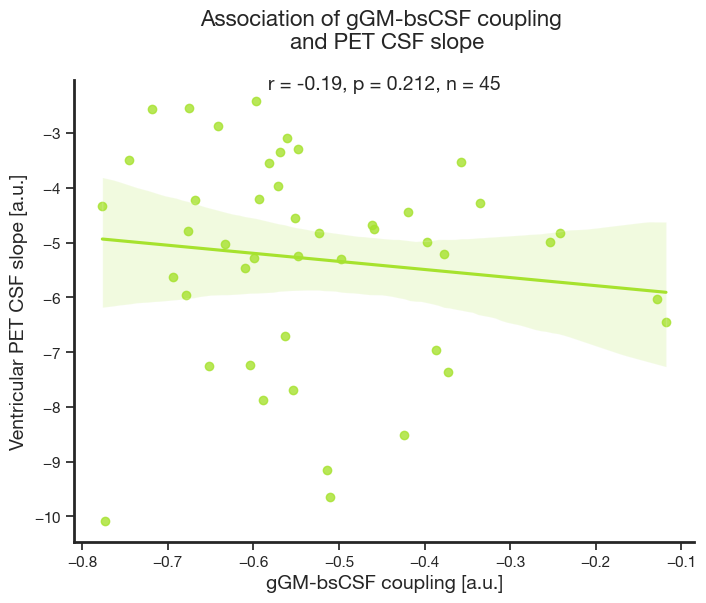

In [18]:
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Control when to switch to scientific

# Association with PET - MEAN striatal SUVR
fig = plt.figure(figsize=(8,6))
corr_plot = sns.regplot(data=hc_bimodal_first_session, x='mean_striatum_value_suv_normalized',y='ventricular_slope', color=(166/255, 226/255, 46/255))
corr_plot.yaxis.set_major_formatter(formatter)
sns.despine()
plt.title('Association of mean striatal SUVR \n and PET CSF slope', weight='bold', fontsize=16, y=1.05)
plt.xlabel('Mean Striatal SUVR [a.u.]', fontsize=14)
plt.ylabel('Ventricular PET CSF slope [a.u.]', fontsize=14)

# Add the correlation values
corr = pg.corr(hc_bimodal_first_session['mean_striatum_value_suv_normalized'], hc_bimodal_first_session['ventricular_slope'], method='spearman')
print(corr)

p_value = corr['p-val'].values[0]
if p_value < 0.001:
    p_str = 'p < 0.001'
else:
    p_str = f'p = {p_value:.3f}'

plt.text(0.5, 0.98, f"r = {corr['r'].values[0]:.2f}, {p_str}, n = {corr['n'].values[0]}", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Association of mean striatal SUVR and PET CSF slope.png')
#fig.savefig(image_path, dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Association of mean striatal SUVR and PET CSF slope.svg')
#fig.savefig(image_path_svg)


# Association with PET - GM amplitude
fig = plt.figure(figsize=(8,6))
corr_plot = sns.regplot(data=hc_bimodal_first_session, x='gm_amplitude_normalized',y='ventricular_slope', color=(166/255, 226/255, 46/255))
corr_plot.yaxis.set_major_formatter(formatter)
sns.despine()
plt.title('Association of gm amplitude \n and PET CSF slope', weight='bold', fontsize=16, y=1.05)
plt.xlabel('gGM amplitude normalized [%]', fontsize=14)
plt.ylabel('Ventricular PET CSF slope [a.u.]', fontsize=14)

# Add the correlation values
corr = pg.corr(hc_bimodal_first_session['gm_amplitude_normalized'], hc_bimodal_first_session['ventricular_slope'], method='spearman')
print(corr)

p_value = corr['p-val'].values[0]
if p_value < 0.001:
    p_str = 'p < 0.001'
else:
    p_str = f'p = {p_value:.3f}'

plt.text(0.5, 0.98, f"r = {corr['r'].values[0]:.2f}, {p_str}, n = {corr['n'].values[0]}", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Association of gGM amplitude normalized and PET CSF slope.png')
#fig.savefig(image_path, dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Association of gGM amplitude normalized and PET CSF slope.svg')
#fig.savefig(image_path_svg)


# Association with PET - GM-CSF coupling
fig = plt.figure(figsize=(8,6))
corr_plot = sns.regplot(data=hc_bimodal_first_session, x='r_gm_csf',y='ventricular_slope', color=(166/255, 226/255, 46/255))
corr_plot.yaxis.set_major_formatter(formatter)
sns.despine()
plt.title('Association of gGM-bsCSF coupling \n and PET CSF slope', weight='bold', fontsize=16, y=1.05)
plt.xlabel('gGM-bsCSF coupling [a.u.]', fontsize=14)
plt.ylabel('Ventricular PET CSF slope [a.u.]', fontsize=14)

# Add the correlation values
corr = pg.corr(hc_bimodal_first_session['r_gm_csf'], hc_bimodal_first_session['ventricular_slope'], method='spearman')
print(corr)

p_value = corr['p-val'].values[0]
if p_value < 0.001:
    p_str = 'p < 0.001'
else:
    p_str = f'p = {p_value:.3f}'

plt.text(0.5, 0.98, f"r = {corr['r'].values[0]:.2f}, {p_str}, n = {corr['n'].values[0]}", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Association of gGM-CSF coupling and PET CSF slope.png')
#fig.savefig(image_path, dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Association of gGM-CSF coupling and PET CSF slope.svg')
#fig.savefig(image_path_svg)
